In [1]:
#ViT
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')


#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=9, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'Experiments/exp_55/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jacobs_Y6/Cutouts/Jacobs_Y6.fits'
hdu_list = fits.open(path_cutouts)
lenses = hdu_list[1].data.astype(np.float32)
data_pos = hdu_list[2].data
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
#data_pos = data_pos.drop(['TILENAME', 'Candidate'], axis=1)
columns_data = data_pos.columns
hdu_list.close()

dataset = ImageDataset(lenses, data_pos, np.zeros(len(lenses), dtype = np.int64), transform=transform)
print(len(dataset))

496


In [8]:
def search(dataset):
    prob_list = []
    search_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=num_workers, shuffle=True)
    images = len(categories)*[np.zeros((1,3,45,45))]
    all_data = len(categories)*[pd.DataFrame()]
    
    for i_batch, sample in enumerate(tqdm(search_loader)):
        #if(i_batch==5): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        output = model(sample_image)
    
        prob = nn.Softmax(dim=1)(output)
        prob_list.append(prob[:,0].detach().cpu().numpy()[0])
        i = prob.argmax(dim=1)
        
        new_df = pd.DataFrame(sample_data, columns=columns_data)
        new_df['Prob'] = prob[:,i].detach()
        all_data[i] = all_data[i].append(new_df, ignore_index=True)
        images[i] = np.append(images[i], np.array(sample_img), axis = 0)
    
    for i in range(len(categories)):
        images[i] = np.delete(images[i], 0, axis = 0)
    
    return(images, all_data, prob_list)
            

In [9]:
categories = ['Positives', 'Rings', 'Smooth', 'Companion', 'SDSS', 'DES_spirals', 'Crowded', 'Errors', 'Most_negatives']
images, all_data, prob_list = search(dataset)

right_data = all_data[0]
wrong_data = pd.DataFrame(columns=columns_data)

for i in range(len(all_data)):
    if(i == 0): continue
    wrong_data = wrong_data.append(all_data[i])

  0%|          | 0/496 [00:00<?, ?it/s]

In [10]:
#Default threshold of probability
print('Total: ' + str(len(lenses)))
print('Detected: {}, not detected: {} \n'.format(len(right_data), len(wrong_data)))

for i in range(len(images)):
    line = 'Labeled as {}: {}'.format(categories[i], len(images[i]))
    print(line)

    
print(' ')
ind = right_data[right_data['Prob'] > 0.949].index
print('Detected with a 0.949 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.974].index
print('Detected with a 0.974 threshold: '+ str(len(ind)))

Total: 496
Detected: 358, not detected: 138 

Labeled as Positives: 358
Labeled as Rings: 2
Labeled as Smooth: 19
Labeled as Companion: 14
Labeled as SDSS: 0
Labeled as DES_spirals: 0
Labeled as Crowded: 43
Labeled as Errors: 0
Labeled as Most_negatives: 60
 
Detected with a 0.949 threshold: 286
Detected with a 0.974 threshold: 270


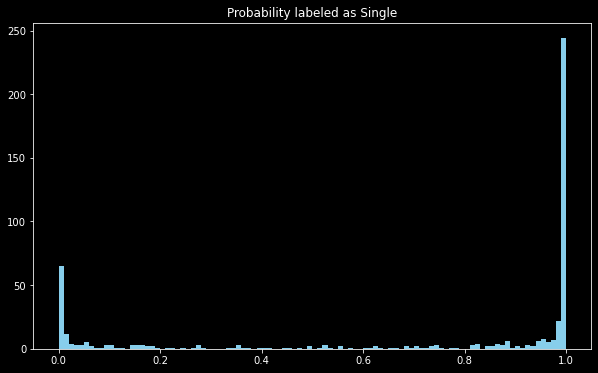

In [11]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [12]:
def make_plot_all(objects, data):
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                #title = 'Mag: {:.2f}, z: {:.2f}'.format(data['MAG_APER_4_G'].values[i+j], data['DNF_ZMEAN_SOF'].values[i+j])
                title = '{:.3f}'.format(data['Prob'].values[i+j])
                print(data['COADD_OBJECT_ID'].values[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

In [13]:
wrong_data.columns

Index(['COADD_OBJECT_ID', 'TILENAME', 'HPIX_16384', 'HPIX_4096',
       'DNF_ZMEAN_SOF', 'RA', 'DEC', 'grade', 'photoz', 'imag',
       'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z',
       'KRON_RADIUS', 'GAP_FLUX_G', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G',
       'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G',
       'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G',
       'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 'IMAFLAGS_ISO_Z', 'Candidate',
       'objectid', 'Prob'],
      dtype='object')

Not identified:
Rings
1060824131
945447192


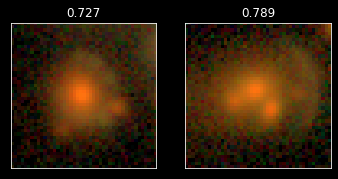

 
Smooth
1011752156
1520163934
926358975
906848959


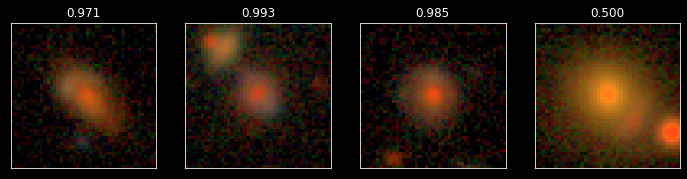

1210605194
1314224614
1397902720
1232668187


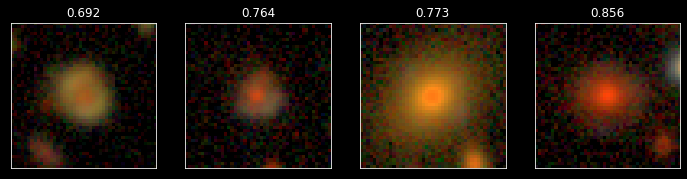

1610019605
1302842192
939977129
922906010


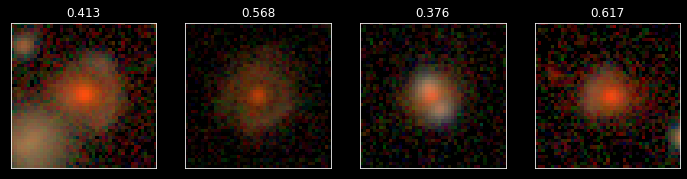

1397786541
1368303750
1363860461
1532546424


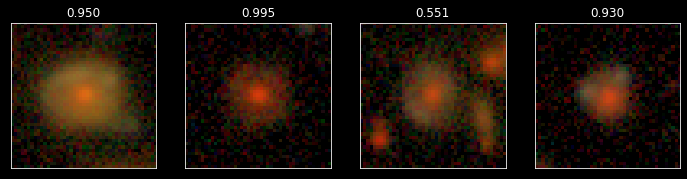

879403239
1050596698
1255097893


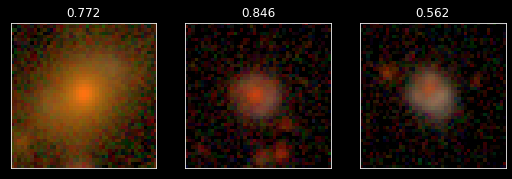

 
Companion
1328384049
1164169304
1097966135
1133966811


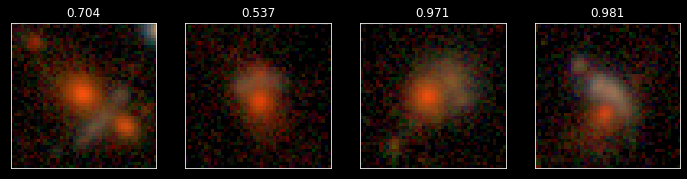

1209117221
1162461053
1324927887
1539517051


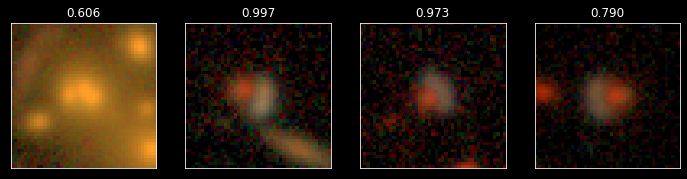

1302030248
1497925832
1403871221
895879313


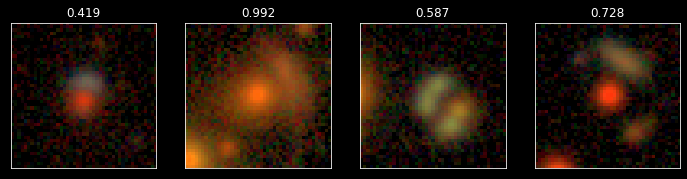

1377288600
1370667532


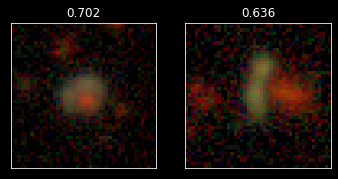

 
SDSS
 
DES_spirals
 
Crowded
1369699810
1605209704
1454422743
1249230135


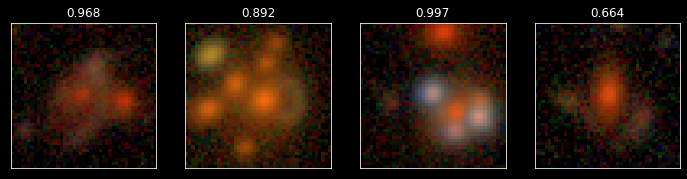

1317179527
1483219056
1568765304
1386311701


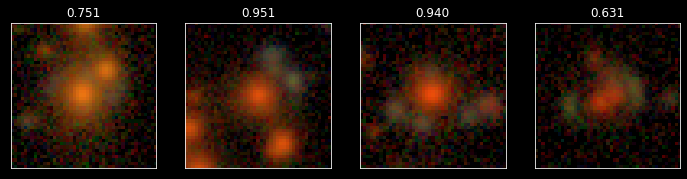

931716591
1419269561
1502820514
1142012795


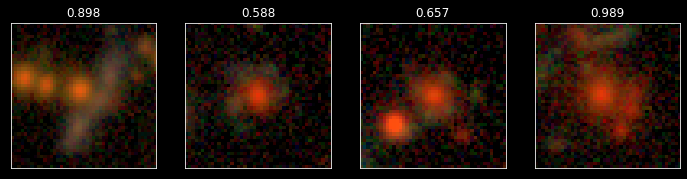

1519335321
1007321586
1006191814
1171125930


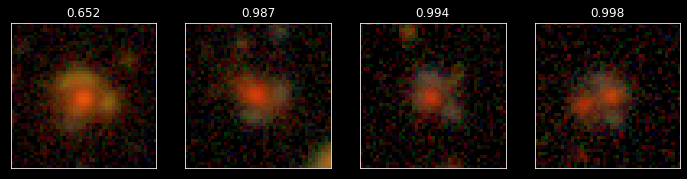

1200974180
1293358551
1218432734
1153726289


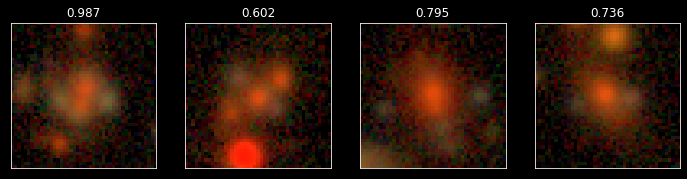

1144824191
1121107640
1502889148
1241426939


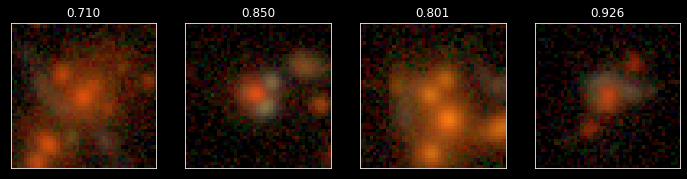

1011953407
1534084624
1122461366
957011358


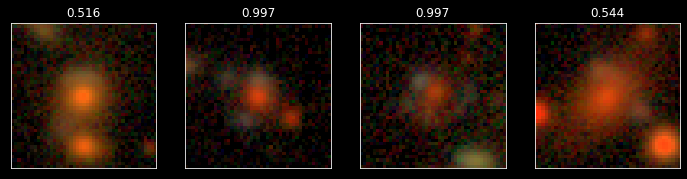

962781218
1222328257
1315004041
1363280855


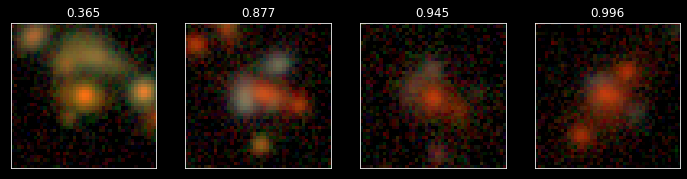

1326909497
1371066768
1544354650
1293464062


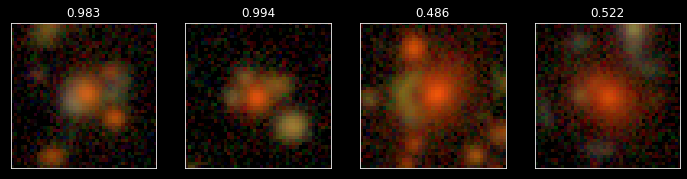

1383664897
884307116
906297047
1437028794


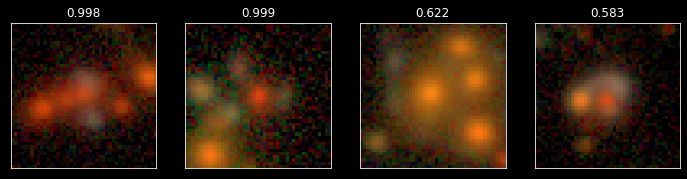

1150981093
1283494898
1389731679


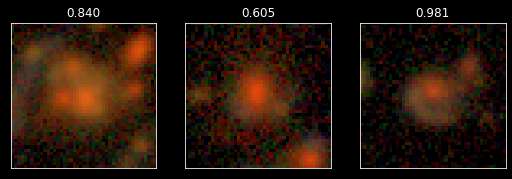

 
Errors
 
Most_negatives
1378074900
1302104402
1478719341
1360521121


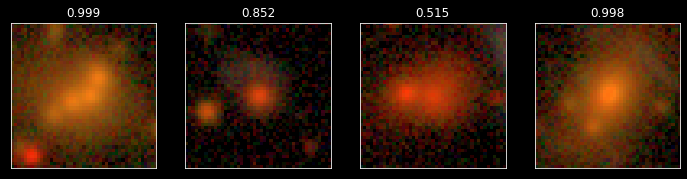

1539815861
1342368789
992157466
1104152493


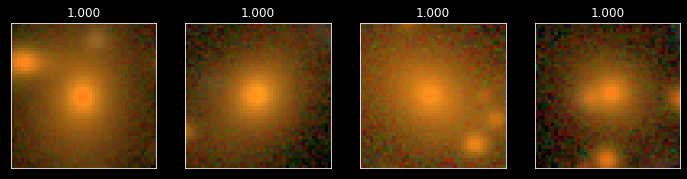

1386329475
1370850549
1387270067
1269458842


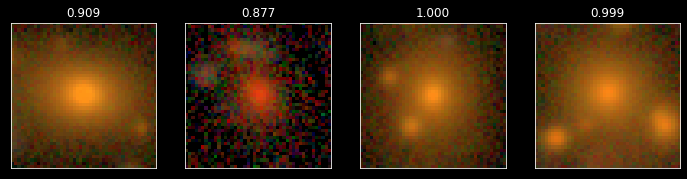

1420520224
1098354338
1322959708
1311859703


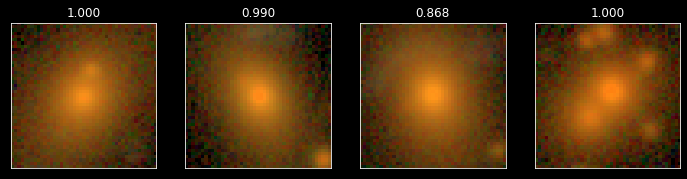

1389753930
1532721542
1518678765
1340791460


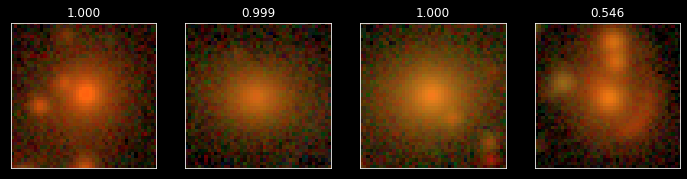

1417005344
1227352718
1046854003
1530676282


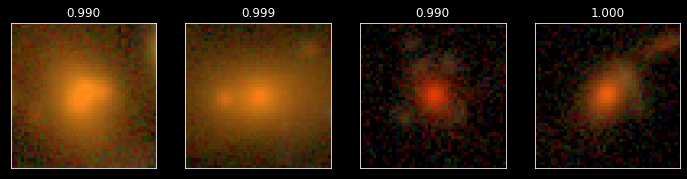

1428022657
955546194
1006400109
1614852030


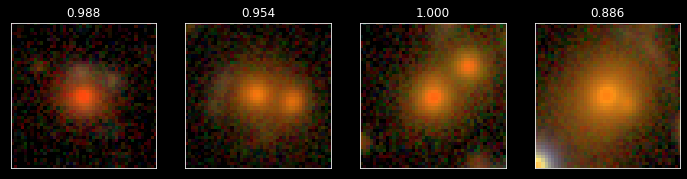

1369627471
1222204219
977331342
1345137000


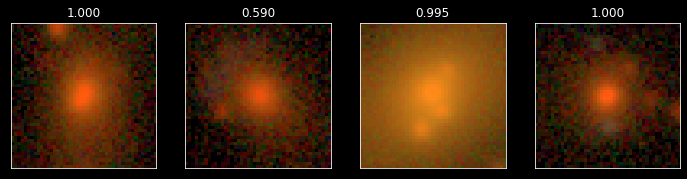

1403056859
952827527
1448395045
977402902


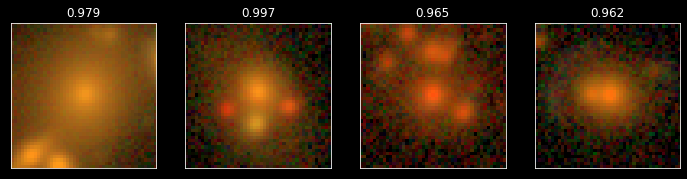

1576743294
1204581428
1200499492
1051762909


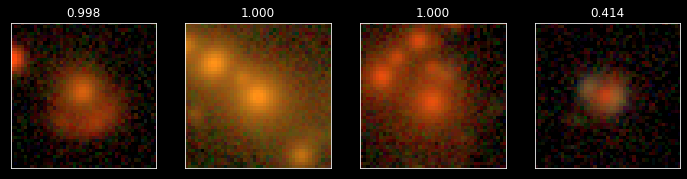

1372004130
1070329410
1144014836
1572658729


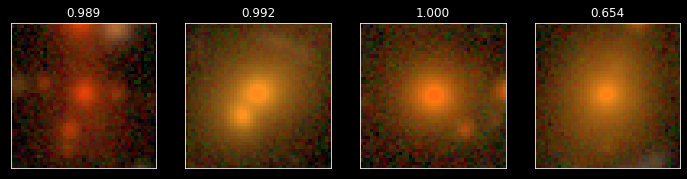

1210817563
943699147
1365603963
992158653


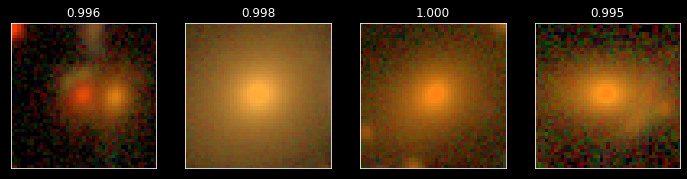

1408480079
933728043
1553993296
1005190830


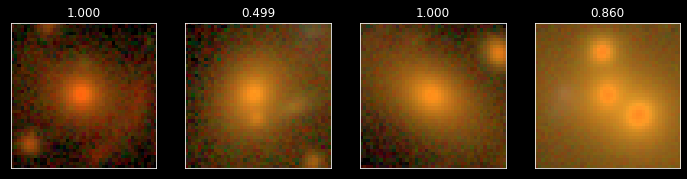

955120453
1333534239
1320102858
925978772


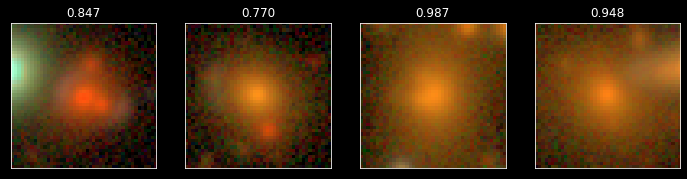

1399379493
1339237461
1375013657
1558511112


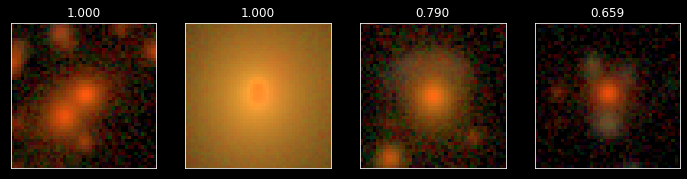

In [14]:
#Not identified
print('Not identified:')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images) == 0): 
        print(' ')
        continue
    make_plot_all(images[i], all_data[i])
    print(' ')

Identified
Positives
1114488763
945275549
1243683190
1339976592


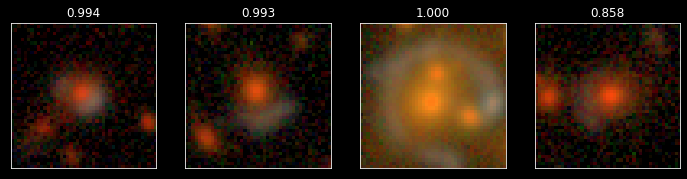

1133082429
1386748971
1300215437
1482528707


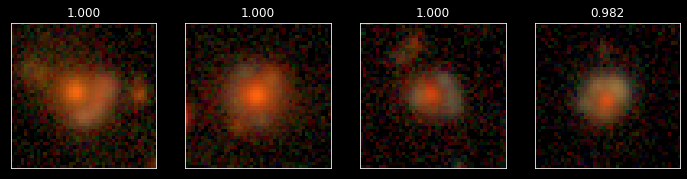

1410370257
1369578668
1503701111
1048920254


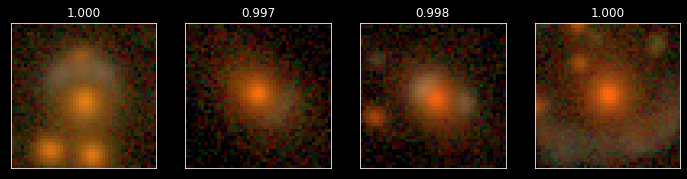

1128511911
1097396471
1208164784
1429276227


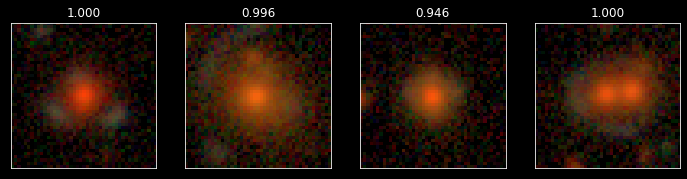

1521719117
1425763095
1461199109
1231933469


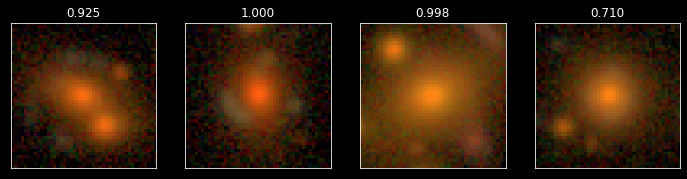

1201264241
1430614124
1495778858
1334070236


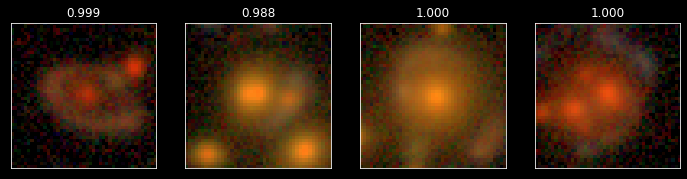

1301570222
1400483784
1610316947
1225062343


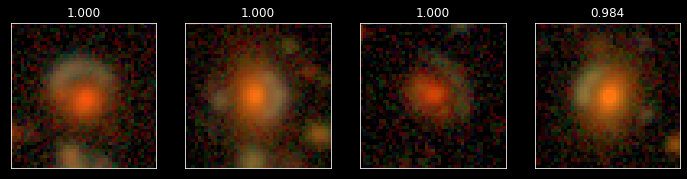

1230981106
1434471332
1517936143
1414539080


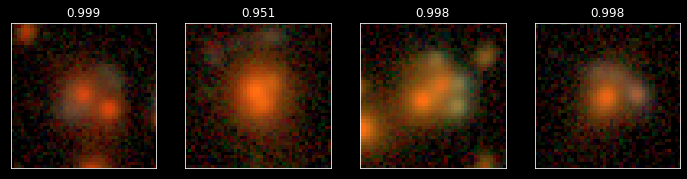

1394900142
1114679464
1358779892
1189746645


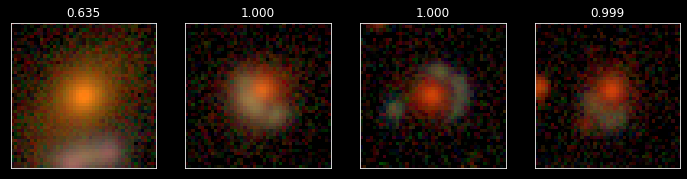

1055293331
1054556683
1535218994
1301081250


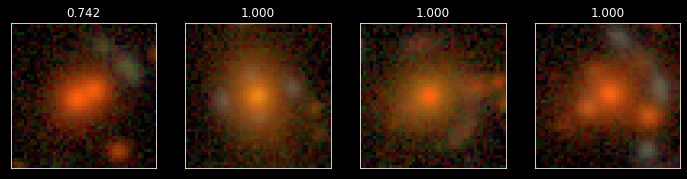

936145598
916018816
1561967167
1275177571


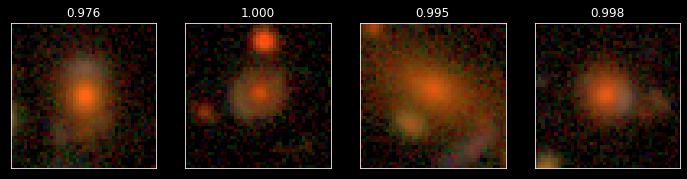

958711616
1136340852
1526026297
1367533692


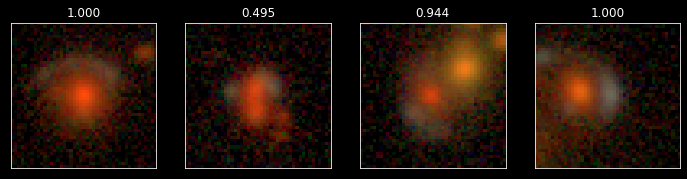

1326680132
981794120
1005730815
1136639478


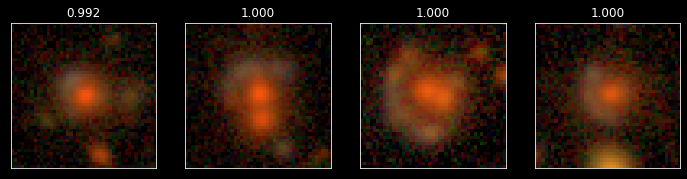

1382310111
1202728609
906132378
1399999613


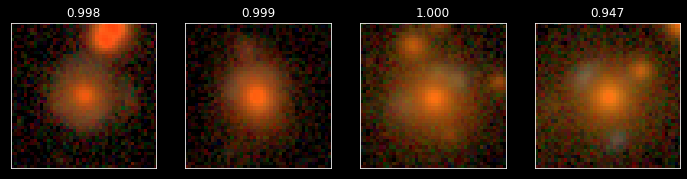

1336392414
1537991730
1453824963
1438681779


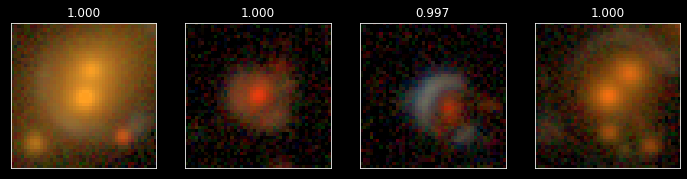

1535198201
1254690304
1088494058
1077357392


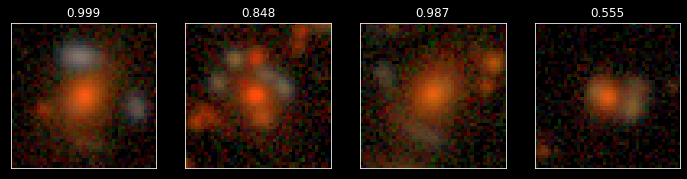

1417914260
1613625064
1211978531
1238557756


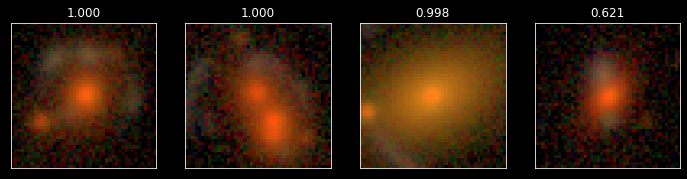

1471530329
1505900316
1154333895
1042565305


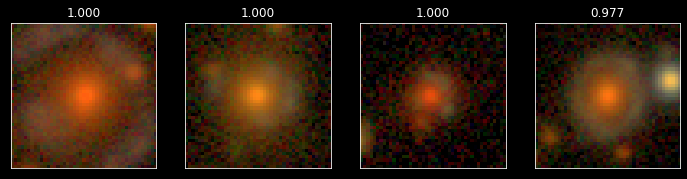

1462363756
957012430
1051491894
1381955752


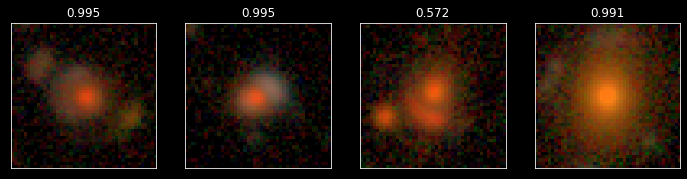

1247311322
1126356733
1171524130
1588446577


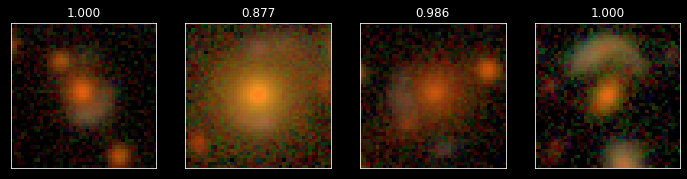

1159009987
1544277856
1491366260
1148039203


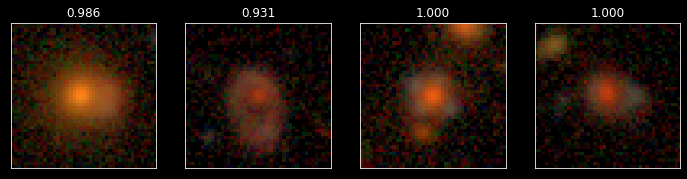

1129303315
1466200592
976812438
1406976127


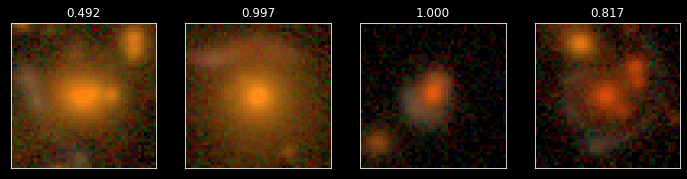

1065852196
1198903075
1346717256
1518164112


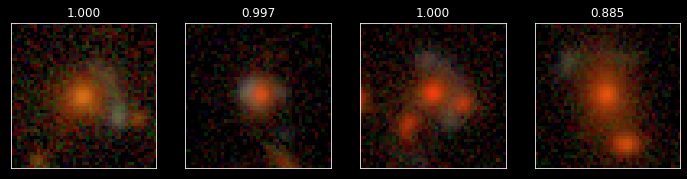

1417024449
1017262705
1015716039
1360486909


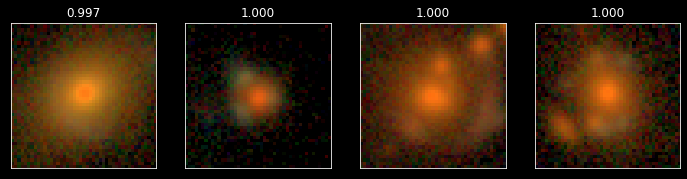

984685369
1522557536
1190538563
884176328


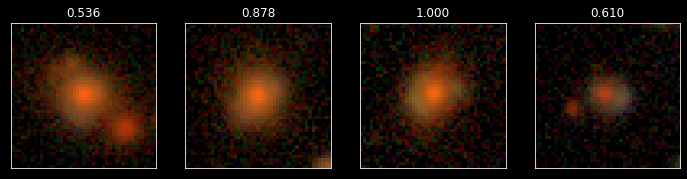

1483061451
1513432178
1172614654
1067328323


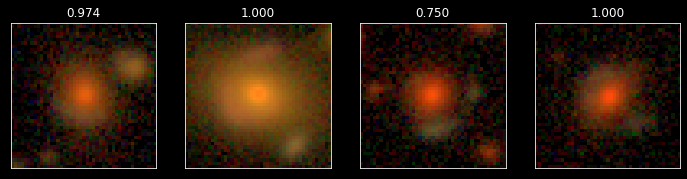

1297126196
1297510452
1325130567
1171046571


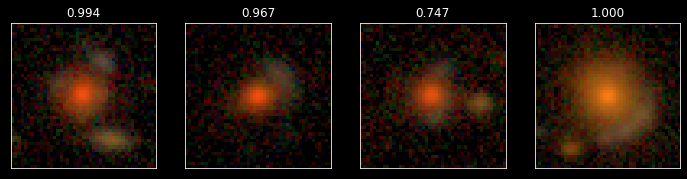

969674177
1529154996
1321063152
1169877794


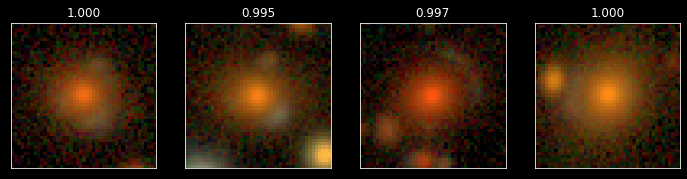

1226327844
1179738251
1510652342
1415379423


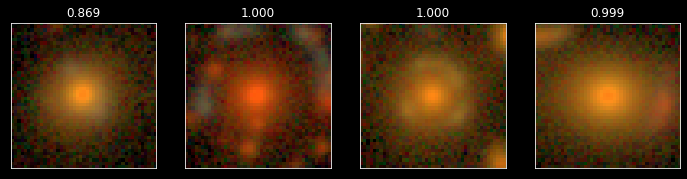

1187097045
1522422819
1088125980
1058744217


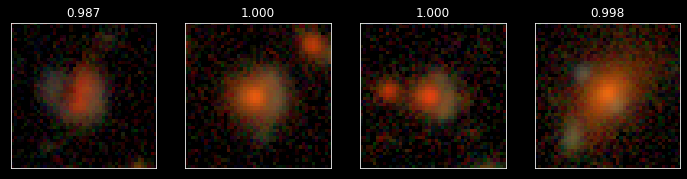

1423965682
1448527037
1034878415
1234418937


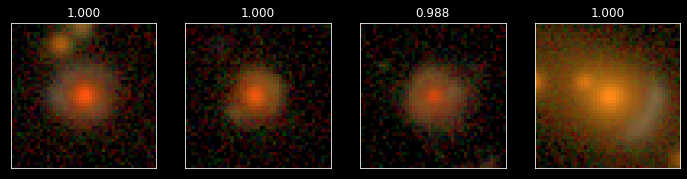

1449752819
1074454732
1532731342
1414531628


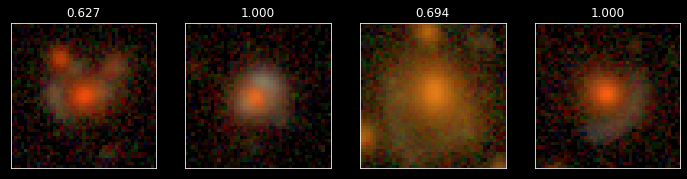

1526034878
1367145325
1545295456
1146656000


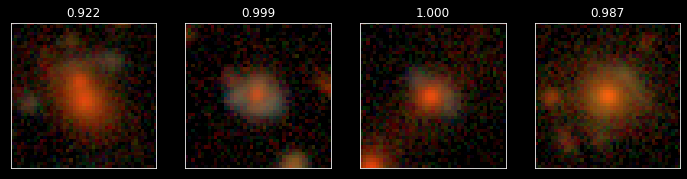

1129249726
1446654681
1051495539
1178164184


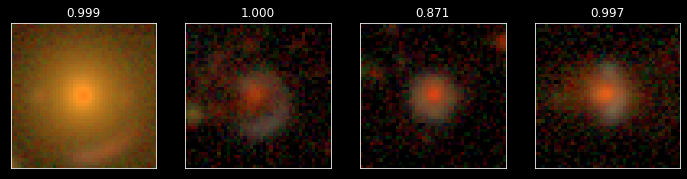

1337371338
1237543091
1153333586
1104760496


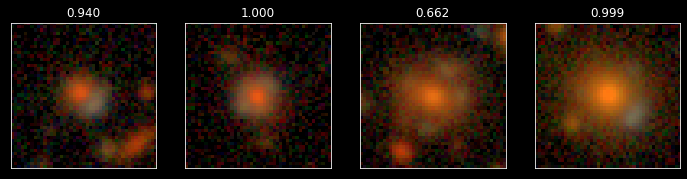

987073198
1159257785
1375955789
913936319


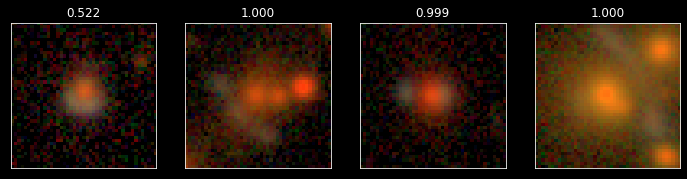

1196484135
921061740
895557736
1287909989


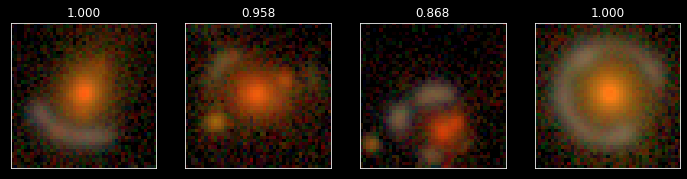

914485495
1243545869
1395103367
1269916975


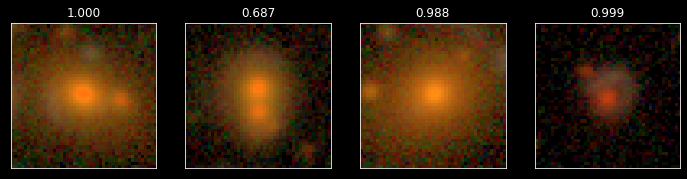

1536678003
1594751764
1177839322
1289249195


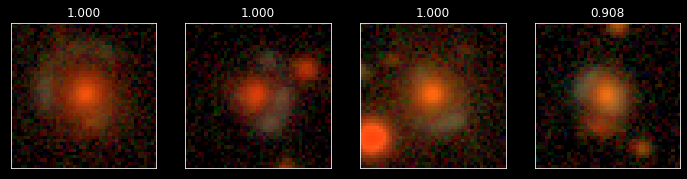

1479275746
1429256248
1449725103
1356429510


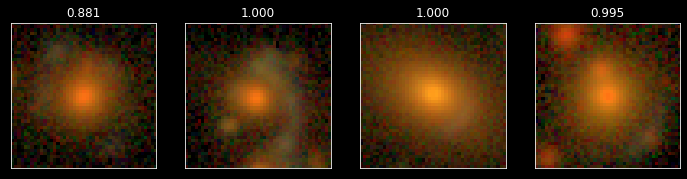

1202909092
1398238029
1237527717
1530473645


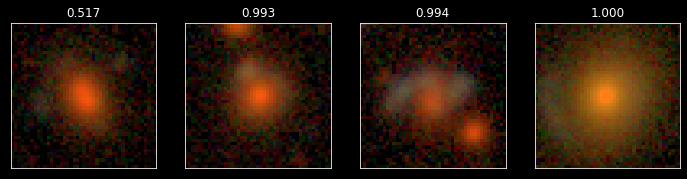

1117638986
1585510883
962178024
1287471303


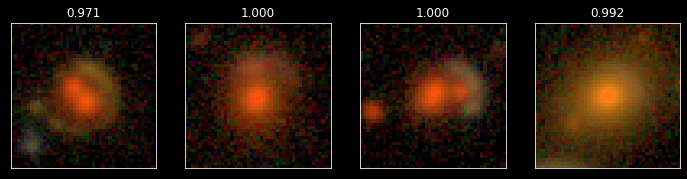

920111245
1425127607
1469887588
1296200194


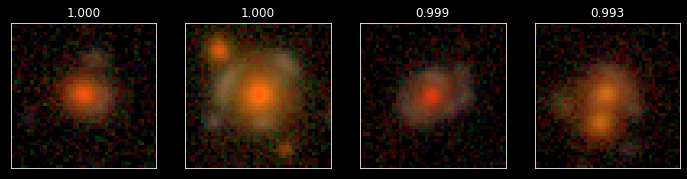

1309246601
1610414328
1323083558
1520310906


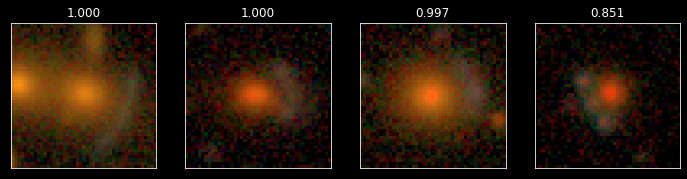

1262961390
1620013669
1512709228
1451845442


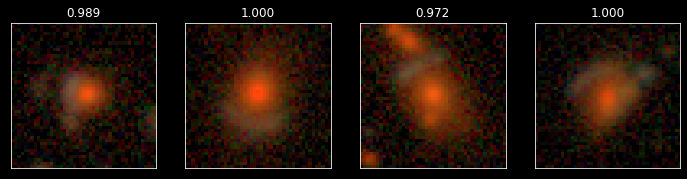

1370519642
1261395335
1418898896
1147402803


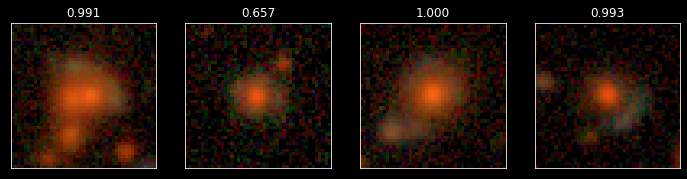

929174879
920001642
982753969
1193586965


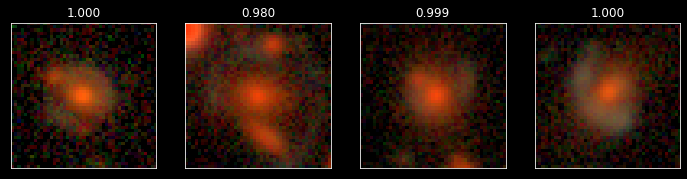

1099283659
1302925237
1170335487
1204327104


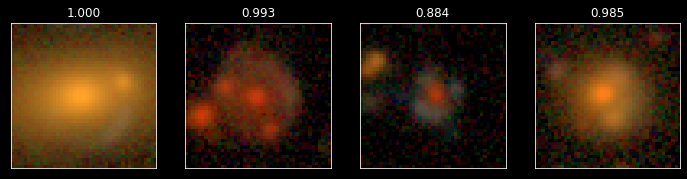

873987650
1452918181
1318291819
1507428529


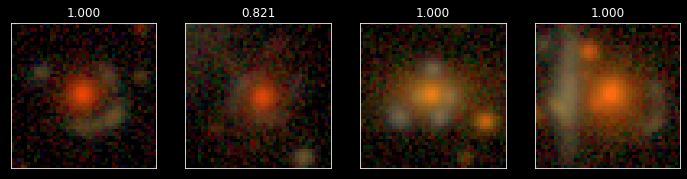

1302396180
1382509325
1272147895
1190063171


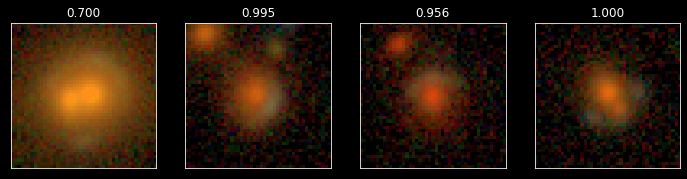

1229530106
1621540995
1466401262
1214520967


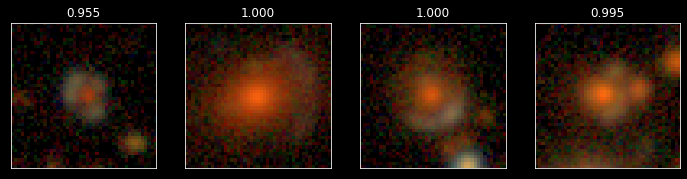

1015396778
928276016
1163516688
1353224538


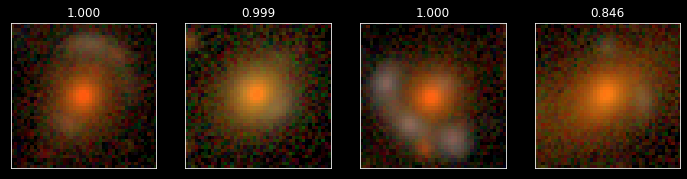

1418184071
984668871
1162332513
1458095582


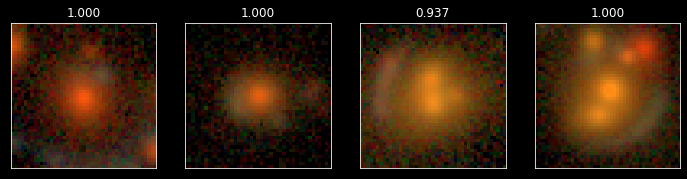

1205139711
1083587736
1379198488
1394738694


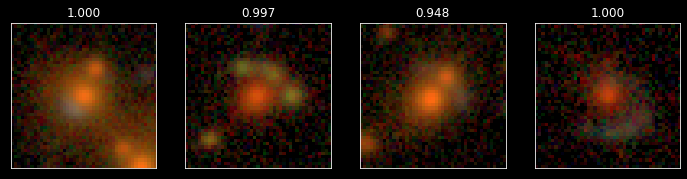

1343418575
1469110768
954133472
1170448654


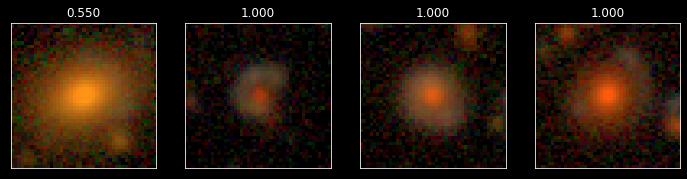

1307017630
1032572319
910130782
1335051094


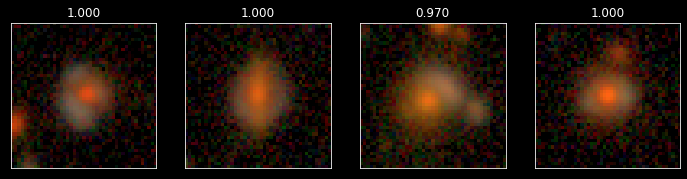

1615848001
1387236198
1032516085
910349095


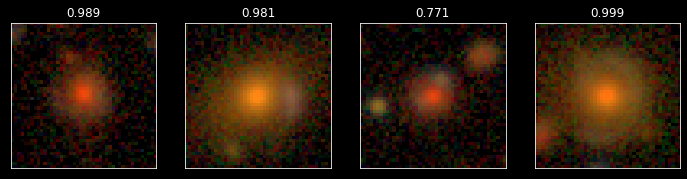

909363984
1364192755
1366134685
1203869644


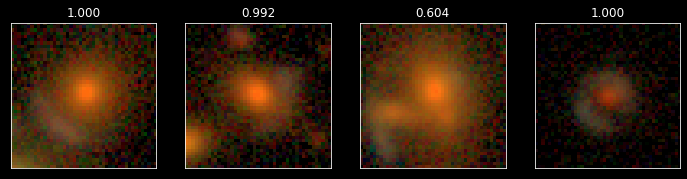

1014709737
1444903123
1452635200
1444457615


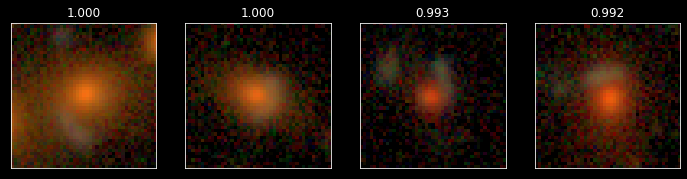

1564067702
916084062
1431464188
1277348353


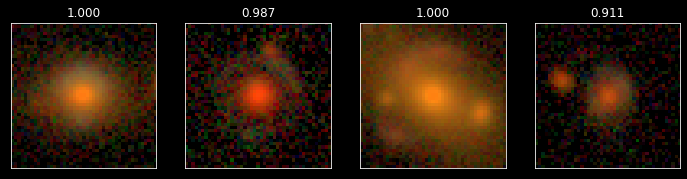

1597714254
1333189566
1616630786
1380201297


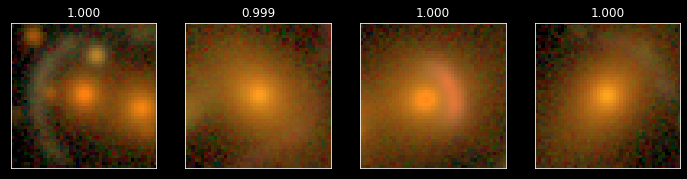

1335651593
1621099134
1470342587
1069698905


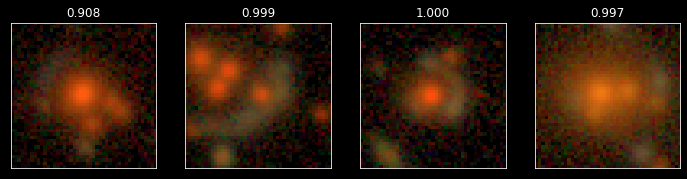

1445672622
1429497103
1224505431
995519978


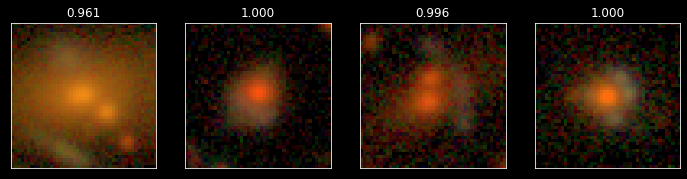

1240557273
1183753773
1196984339
1493630017


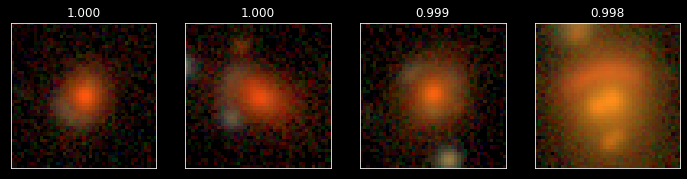

896927669
1042572859
996246835
1588291406


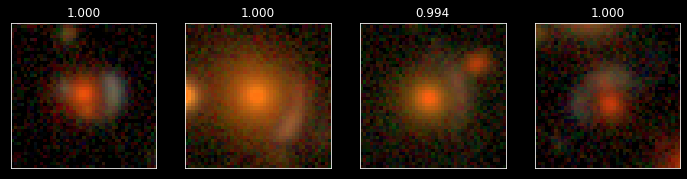

1039481727
1235910677
937223786
1445651907


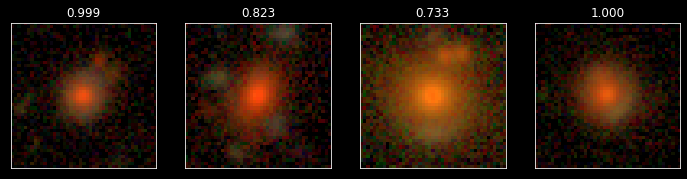

1325770979
1447194025
1079352949
1472301145


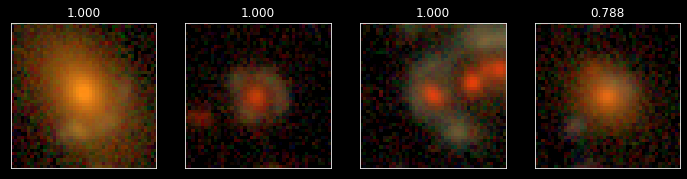

1616781749
1567398970
1172896430
1413196615


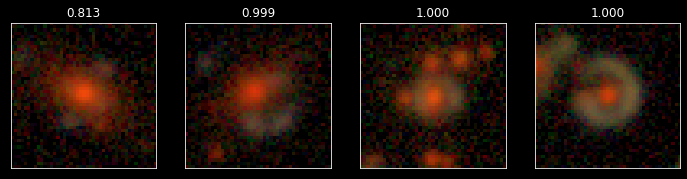

1342755111
1015482810
1612075297
1194195904


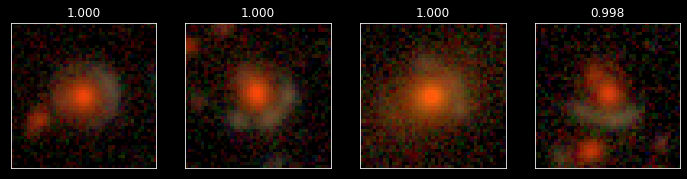

1235391858
994248020
1136960821
1377305692


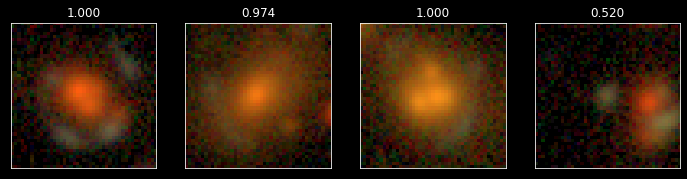

1305035224
1499393985
902264453
1567663479


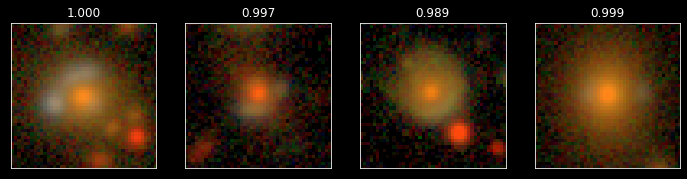

1027060361
963722618
1437352224
1385113597


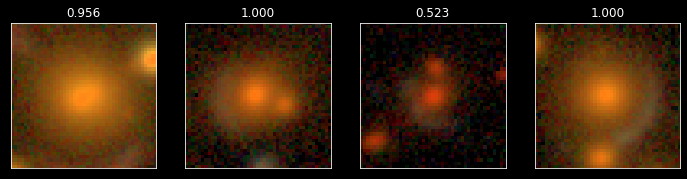

1417265726
1186271916
1555731785
1032630238


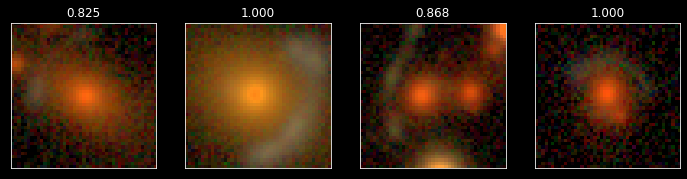

1173896612
1279191353
1151529929
1194748640


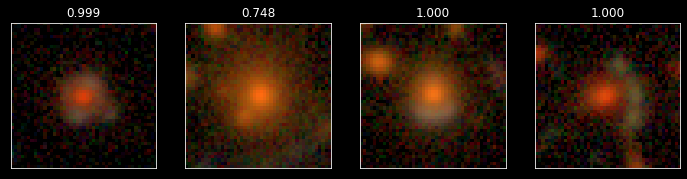

1482935849
1343800193
1341869055
1267465843


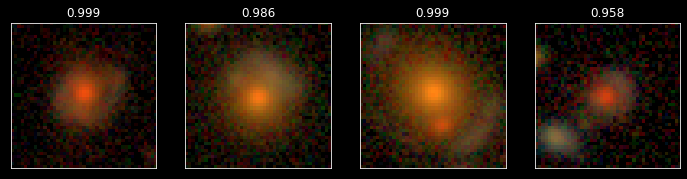

997111564
1313916462
1135365822
1463283017


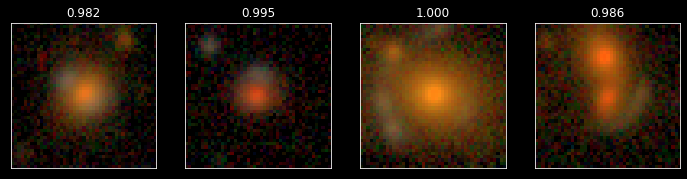

924174668
1371478188
1554912970
973022479


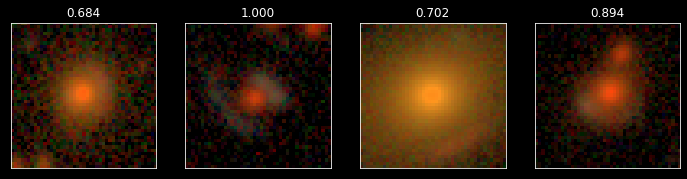

947096663
1463632393
1579060716
885335814


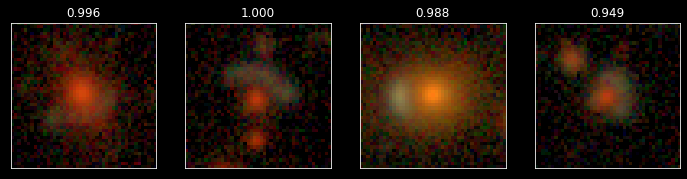

1286124138
1178407449
1577636680
1403872468


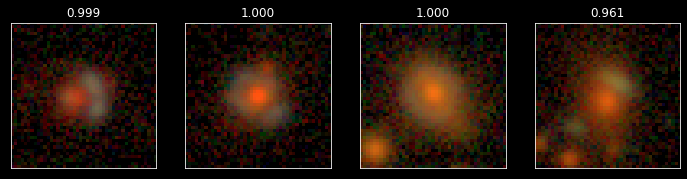

1128123081
1080776069
1301526898
1559829914


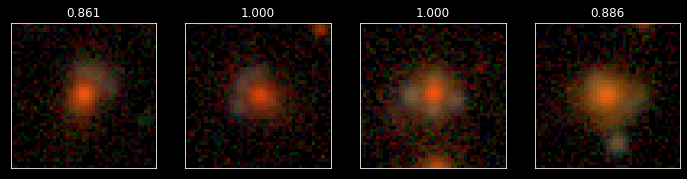

914331956
1486397038
1504184978
931521165


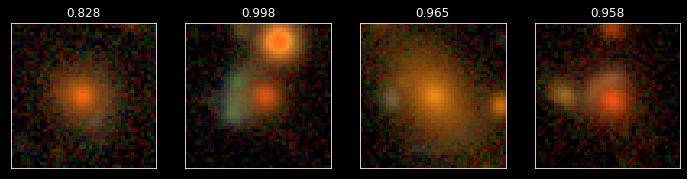

1332137965
1396857779
1441805121
1498870663


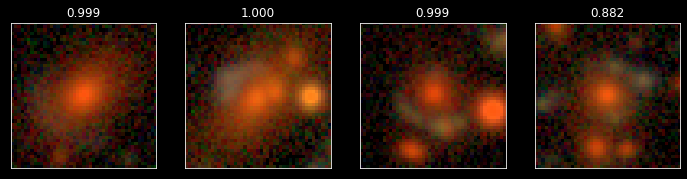

918607334
1355312134
1048865468
1231169165


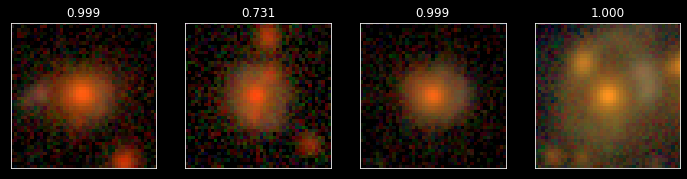

1337591104
1477822151
1056483458
1360738327


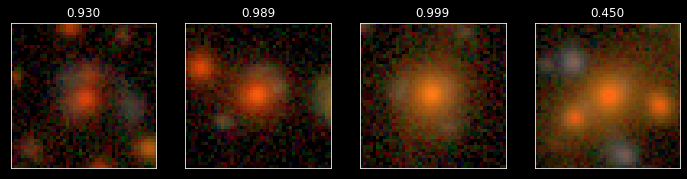

1484242359
1404582289
1088115093
1331280148


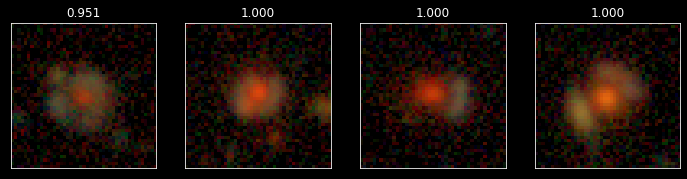

1569046306
1329554469
1104763422
1027961497


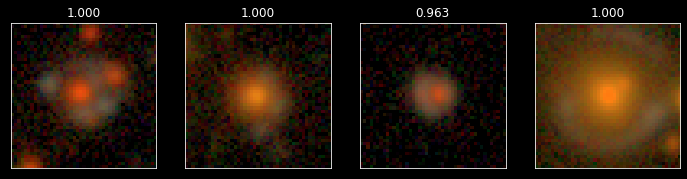

1286831512
1195735459
1493707761
1093259184


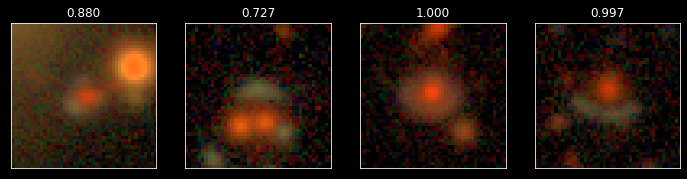

1022086875
1390913339
1591517201
1031154124


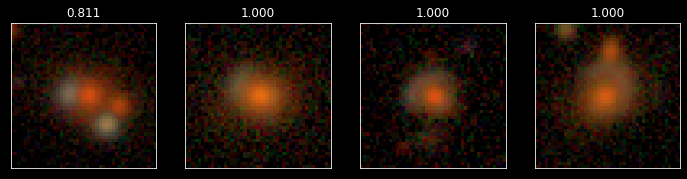

1529405528
1225134030
1358003440
1461036110


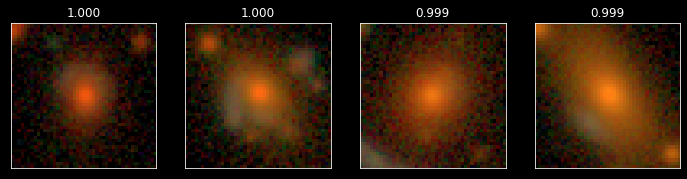

1253420372
1027020579


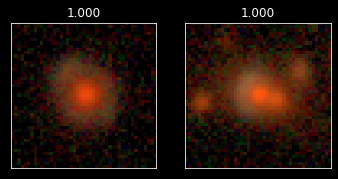

In [15]:
#Identified
print('Identified')
print(categories[0])
make_plot_all(images[0], all_data[0])

In [16]:
names = ['Prob', 'grade', 'photoz', 'imag', 'DNF_ZMEAN_SOF', 'FLUX_RADIUS_G', 'KRON_RADIUS', 'GAP_FLUX_G',
       'MAG_AUTO_G', 'MAG_APER_4_G', 'MAG_APER_8_G']

right_data = right_data[right_data['imag'] < 50]
wrong_data = wrong_data[wrong_data['imag'] < 50]

In [17]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_data[name], wrong_data[name]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    
    plt.subplot(1,2,2)
    plt.title(name)
    plt.hist(right_data[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_data[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    plt.show()
        

def make_all_histos():
    for name in names:
        make_histo(name)

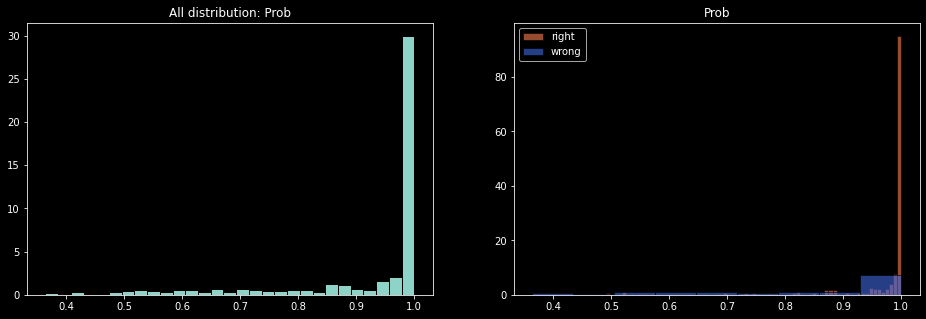

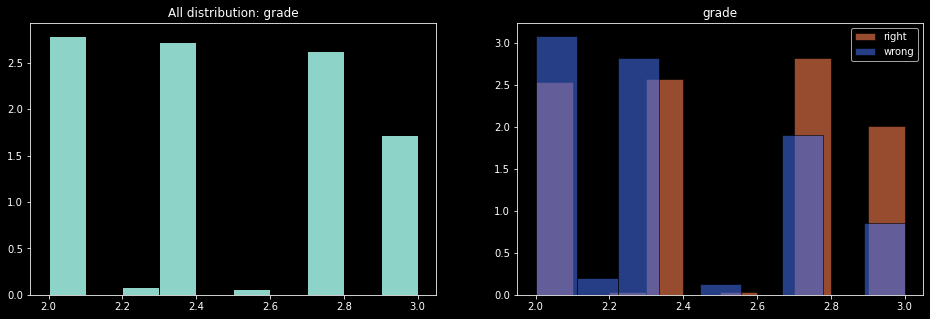

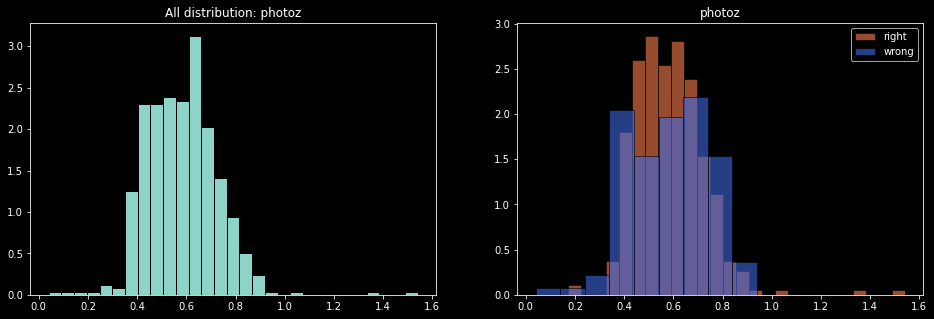

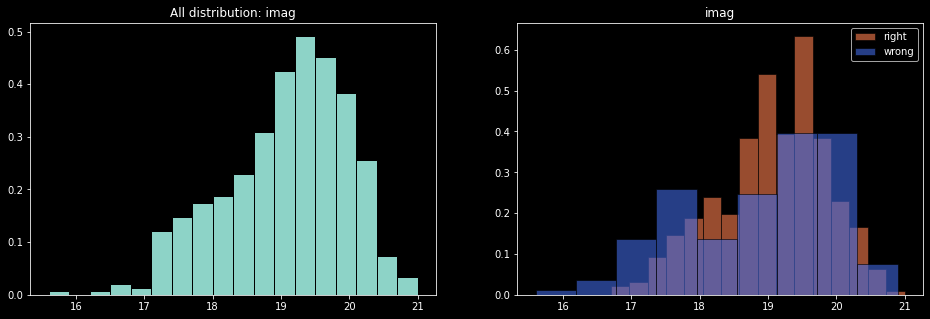

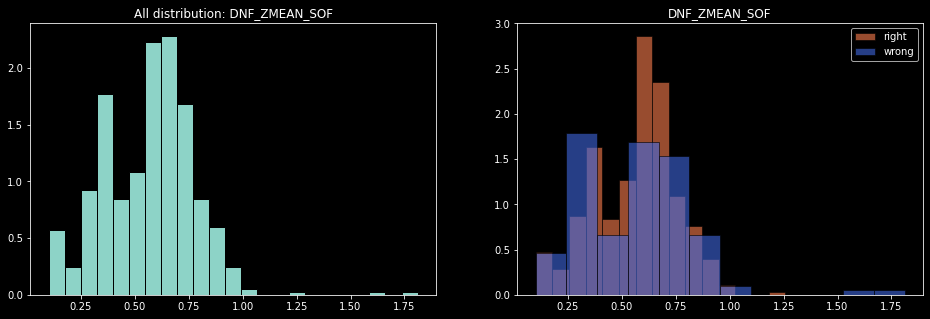

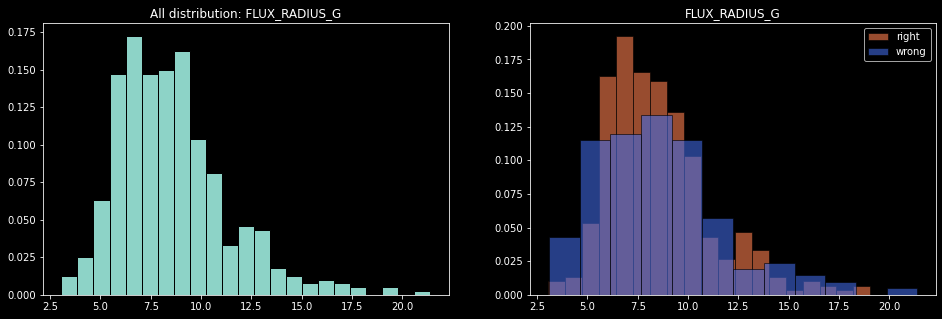

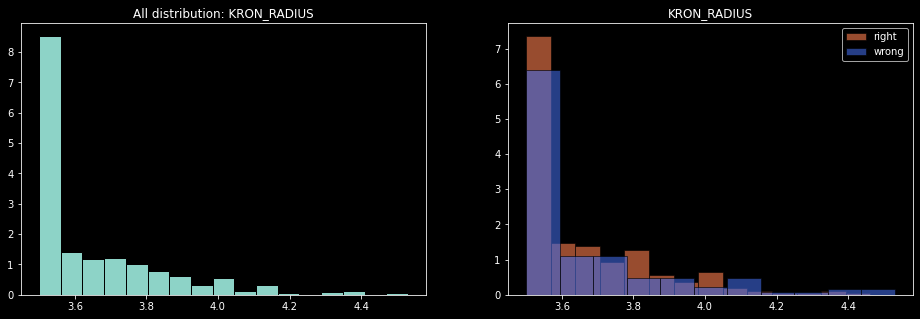

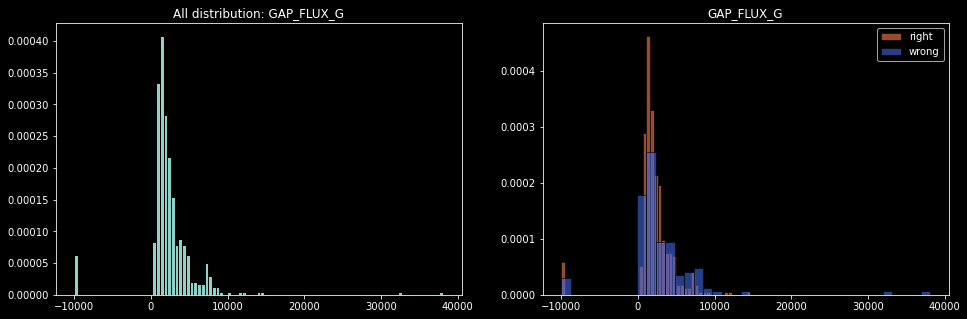

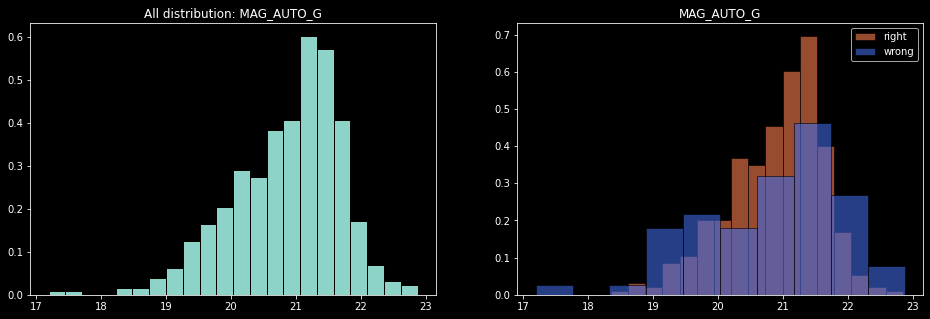

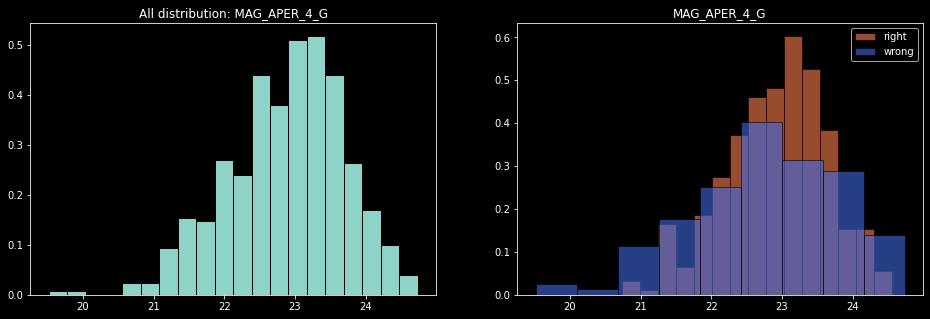

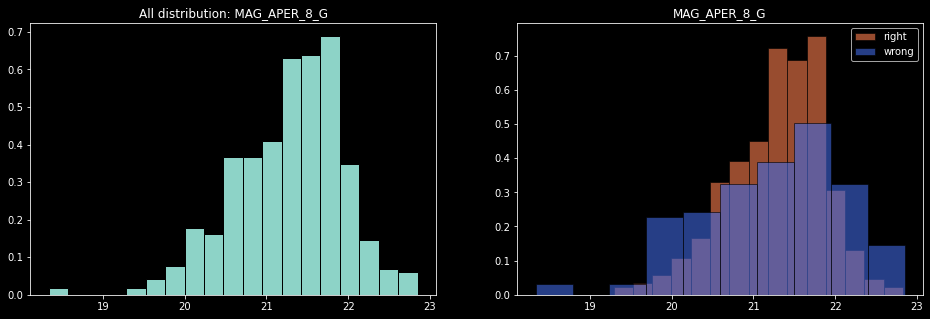

In [18]:
make_all_histos()

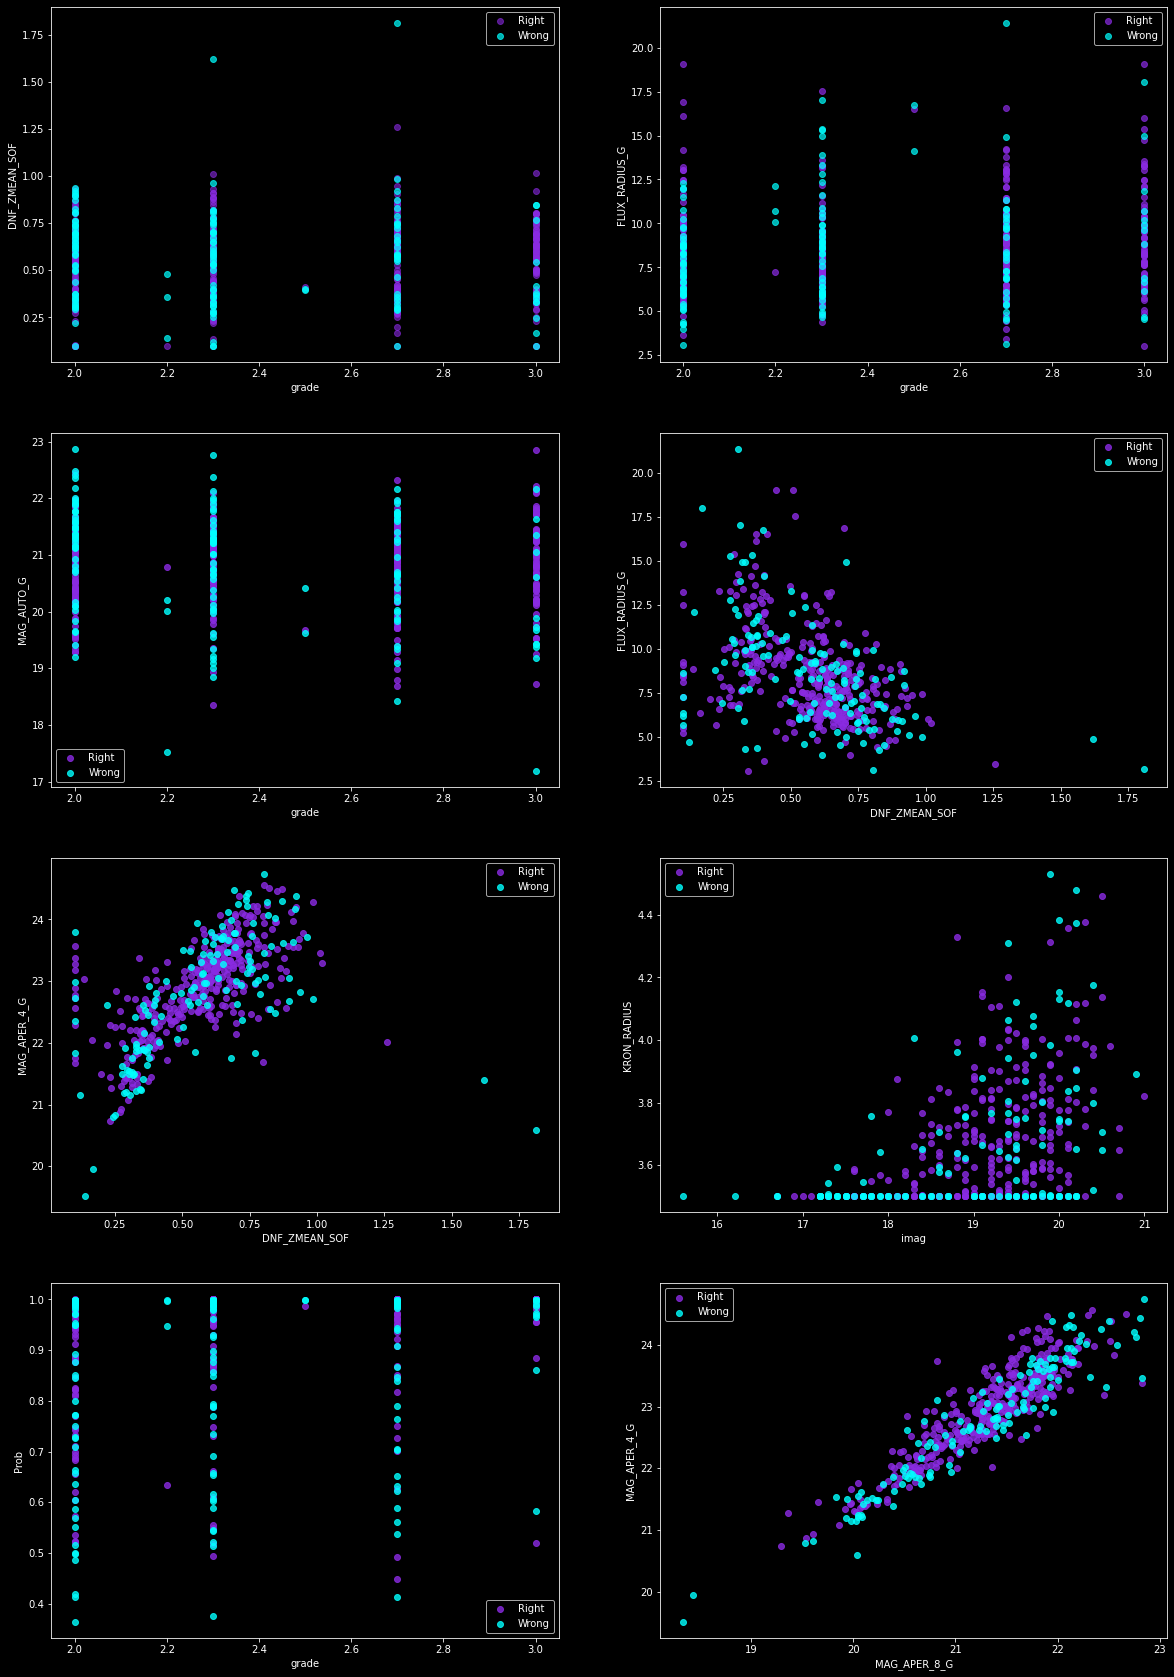

In [19]:
plt.figure(figsize=(20,30)) 

plt.subplot(4,2,1)
plt.xlabel(names[1])
plt.ylabel(names[4])
plt.scatter(right_data[names[1]], right_data[names[4]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[4]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(4,2,2)
plt.xlabel(names[1])
plt.ylabel(names[5])
plt.scatter(right_data[names[1]], right_data[names[5]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[5]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(4,2,3)
plt.xlabel(names[1])
plt.ylabel(names[8])
plt.scatter(right_data[names[1]], right_data[names[8]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[8]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,4)
plt.xlabel(names[4])
plt.ylabel(names[5])
plt.scatter(right_data[names[4]], right_data[names[5]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[4]], wrong_data[names[5]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,5)
plt.xlabel(names[4])
plt.ylabel(names[9])
plt.scatter(right_data[names[4]], right_data[names[9]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[4]], wrong_data[names[9]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,6)
plt.xlabel(names[3])
plt.ylabel(names[6])
plt.scatter(right_data[names[3]], right_data[names[6]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[6]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.subplot(4,2,7)
plt.xlabel(names[1])
plt.ylabel(names[0])
plt.scatter(right_data[names[1]], right_data[names[0]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[0]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend()     

plt.subplot(4,2,8)
plt.xlabel(names[10])
plt.ylabel(names[9])
plt.scatter(right_data[names[10]], right_data[names[9]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[10]], wrong_data[names[9]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend()   

plt.show()